In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.preprocessing import image
import os

In [2]:
# Dataset paths
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

In [3]:
# Image properties
img_size = 48
batch_size = 64

In [4]:
# Data augmentation
train_datagen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    rescale=1./255,
    zoom_range=0.2,
    rotation_range=10,
    validation_split=0.2
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Load data
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="training"
)

validation_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical",
    subset="validation"
)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(img_size, img_size),
    batch_size=batch_size,
    color_mode="grayscale",
    class_mode="categorical"
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [6]:
# Model architecture
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(128, (5,5), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.25),

    Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Conv2D(512, (3,3), padding='same', activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    BatchNormalization(),
    MaxPooling2D(2,2),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Dense(7, activation='softmax')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Compile the model
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

In [9]:
# Train the model
epochs = 100
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=[reduce_lr, early_stop]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


359/359 ━━━━━━━━━━━━━━━━━━━━ 182s 452ms/step - accuracy: 0.1662 - loss: 14.7682 - val_accuracy: 0.2406 - val_loss: 13.5146 - learning_rate: 1.0000e-04
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 147ms/step - accuracy: 0.1894 - loss: 13.3421 - val_accuracy: 0.2487 - val_loss: 12.0851 - learning_rate: 1.0000e-04
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 53s 146ms/step - accuracy: 0.2023 - loss: 11.9085 - val_accuracy: 0.2513 - val_loss: 10.6205 - learning_rate: 1.0000e-04
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.2142 - loss: 10.4406 - val_accuracy: 0.2498 - val_loss: 9.1743 - learning_rate: 1.0000e-04
Epoch 5/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 149ms/step - accuracy: 0.2177 - loss: 9.0555 - val_accuracy: 0.2519 - val_loss: 7.9027 - learning_rate: 1.0000e-04
Epoch 6/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step - accuracy: 0.2211 - loss: 7.7618 - val_accuracy: 0.2632 - val_loss: 6.7281 - learning_rate: 1.0000e-04
Epoch 7/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s

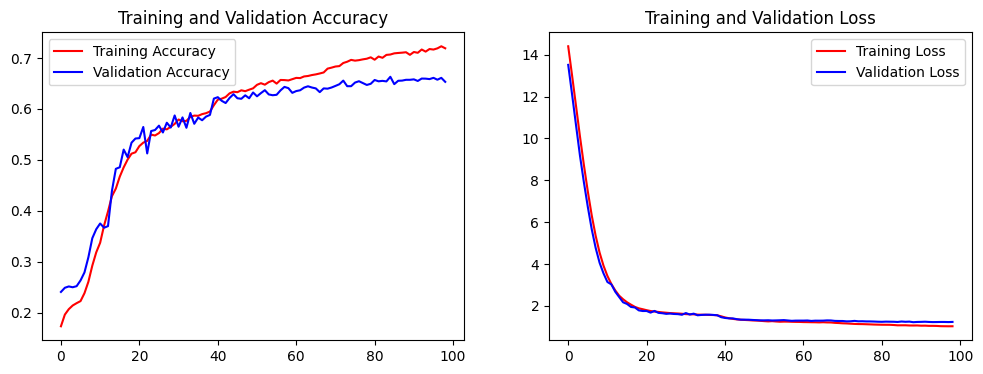

In [10]:
# Plot performance
def plot_metrics(history):
    epochs_range = range(len(history.history['accuracy']))

    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, history.history['accuracy'], 'r', label='Training Accuracy')
    plt.plot(epochs_range, history.history['val_accuracy'], 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, history.history['loss'], 'r', label='Training Loss')
    plt.plot(epochs_range, history.history['val_loss'], 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

plot_metrics(history)

In [11]:
# Evaluate model
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)
print(f"Final Train Accuracy: {train_acc * 100:.2f}% | Validation Accuracy: {test_acc * 100:.2f}%")

359/359 ━━━━━━━━━━━━━━━━━━━━ 44s 124ms/step - accuracy: 0.7777 - loss: 0.8713
113/113 ━━━━━━━━━━━━━━━━━━━━ 50s 448ms/step - accuracy: 0.6718 - loss: 1.2191
Final Train Accuracy: 77.52% | Validation Accuracy: 67.11%


In [12]:
# Single image prediction function
def predict_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode="grayscale")
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    img = img.reshape(1, 48, 48, 1)

    prediction = model.predict(img)[0]
    class_index = np.argmax(prediction)

    label_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Neutral', 5:'Sad', 6:'Surprise'}
    print(f"Predicted Emotion: {label_dict[class_index]}")

    plt.imshow(img[0, :, :, 0], cmap='gray')
    plt.title(f"Emotion: {label_dict[class_index]}")
    plt.axis('off')
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion: Fear


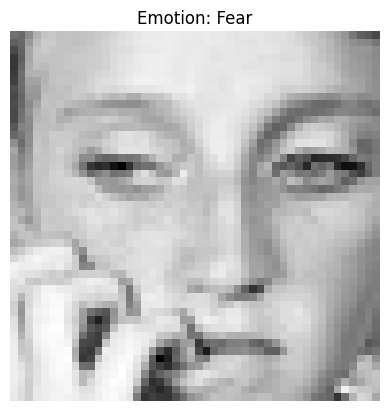

In [13]:
# Test prediction
predict_emotion("/kaggle/input/fer2013/test/fear/PrivateTest_11014592.jpg")

In [14]:
# Save model
model.save('model_fer2013_optimized.h5')
